<a href="https://colab.research.google.com/github/cosmo3769/keras.io_examples/blob/main/natural%20language%20processing/Text_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparing text data

* Text Standardization - converting uppercase to lowercase in text or removing punctuation.
* Text splitting (tokenization) - split text into units(tokens), such as characters, words or group of words.
* Vocabulary indexing - Convert each such token into a numerical vector. Usually, it involves first indexing all the tokens in the data.
* Using the TextVectorization layer


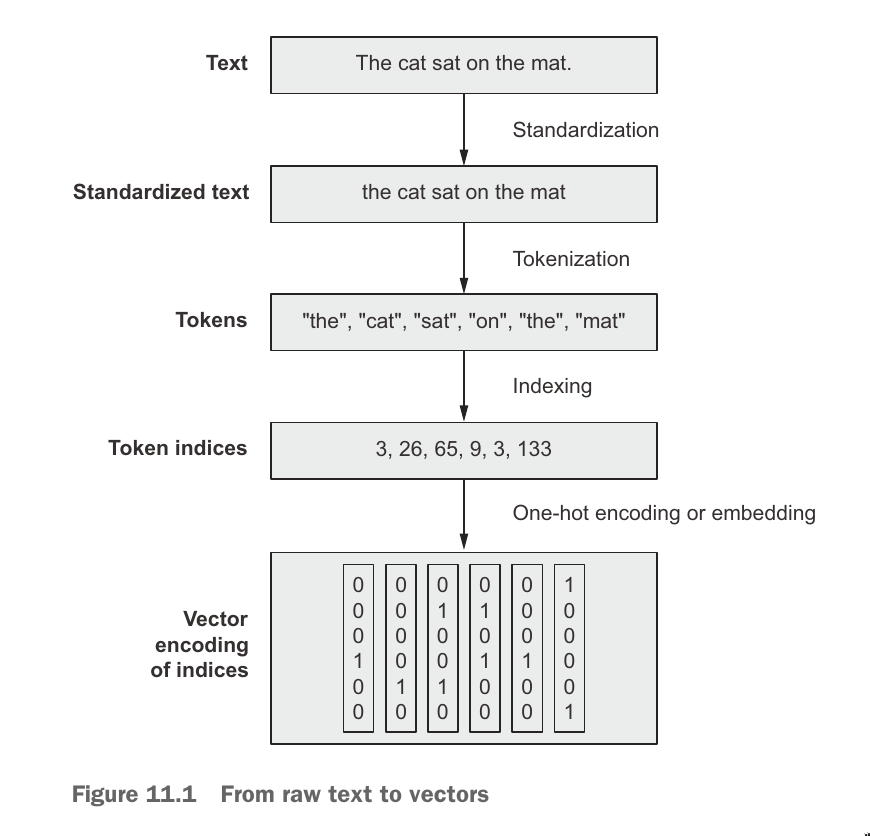

## Text Standardization

It is a basic form of feature engineering that aims to erase encoding differences that you don’t want your model to have to deal with. 

Techniques:

* convert to lowercase and remove punctuation characters.
* convert special characters to a standard form, such as replacing “é” with “e,” “æ” with “ae,” and so on.
* Stemming: converting variations of a term into a single shared representation. (turning “caught” and “been catching” into “[catch]” or “cats” into “[cat]”)

This will ensure that your model will require less training data and will generalize better—it won’t need abundant examples of both “Sunset” and “sunset” to learn that they mean the same thing, and it will be able to make sense of “México” even if it has only seen “mexico” in its training set.

standardization may also erase some amount of information, so always keep the context in mind: for instance, if you’re writing a model that extracts questions from interview articles, it should definitely treat “?” as a separate token instead of dropping it, because it’s a useful signal for this specific task.

## Tokenization (Text Splitting)

Break standardized text into units to vectorize(tokens).

* Word-level tokenization: tokens are space-separated (or punctuation- separated) substrings. We can further split word into sub-words.(staring into star+ing, called into call+ed)
* N-gram tokenization: tokens are groups of N consecutive words.(“the cat” or “he was” would be 2-gram tokens, called bigrams).
* Character-level tokenization: each character is its own token. You can use it in specialized contexts like text generation or speech recognition.

Text-processing models: 

* sequence models: this cares about word order, It uses word-level tokenization.
* bag-of-words models: treat input words as a set, discards their original order. It uses N-gram tokenization.

N-grams are a way to artificially inject a small amount of local word order information into the model.


## Vocabulary Indexing

Build an index of all terms found in the training data (the “vocabulary”), and assign a unique integer to each entry in the vocabulary.

Convert that integer into a vector encoding that can be processed by a
neural network, like a one-hot vector.

NOTE: It's common to restrict vocabulary to the most common words because indexing those rare terms would result in an excessively large feature space,
where most features would have almost no information content.

* OOV Token: "here was a word we did not recognize". given index 1 when encoding words to integers.(OOV index) When decoding integer to words, this index 1 changes to "[UNK]".
* Mask Token: "ignore me, I’m not a word". given index 0. It is used to pad sequence data. If they are two sequences, one longer and one shorter, the shorter sequence needs to be of same length to that of the longer sequence.(Two sequence before padding: [5, 7, 124, 4, 89] and [8, 34, 21], Two sequence after padding: [[5, 7, 124, 4, 89][8, 34, 21, 0, 0]])